# Jar Targetting System
## Training Program
Liam Akkerman, Aidan Hunter

In [1]:
# import os
# os._exit(00)

In [2]:
# load libraries

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [3]:
# coords_to_image(y_data_raw, shape=(*x_data.shape[:3], 1))
def coords_to_image(coords, shape=(500,500,1), high_value=0.999):
    '''
    DEPRECIATED
    convert a list of tuples of jar coordinates into an image with dots at the centre location.
    '''

    image = np.zeros(shape, dtype=np.float16)
    for i, pt_list in enumerate(coords): # TODO rewrite with better looping
        for pt in pt_list:
            image[i, int(np.floor(pt[0])), int(np.floor(pt[1])), :] = high_value 
    return image

In [4]:
# coords_to_image(y_data_raw, shape=(*x_data.shape[:3], 1))
def coords_to_image_full(coords, shape=(500,500,1), high_value=0.999):
    '''
    convert a list of tuples of jar coordinates into an image with entire circles filled. makes a faded edge.
    '''

    from skimage.draw import disk

    image = np.zeros(shape, dtype=np.float16)
    for i, pt_list in enumerate(coords): # TODO rewrite with better looping
        for pt in pt_list:
            rr, cc = disk(pt, 35) # draw a circle
            image[i, cc, rr, :] = high_value/3 # write it onto the image
            rr, cc = disk(pt, 32) 
            image[i, cc, rr, :] = high_value/2
            rr, cc = disk(pt, 29) 
            image[i, cc, rr, :] = high_value
    
    return image

In [5]:
def image_to_coords(image, high_threashold=0.5):
    '''
    DEPRECIATED
    convert an image of jar centres into a list of tuples. the image contains a pixel at each coordinate of jar centres.
    '''

    if not image.ndim == 3:
        if image.ndim == 4 and image.shape[0] == 1:
            image = np.reshape(image, image.shape[1:])
        else:
            raise ValueError('misshapped image')
    
    coords = list()
    for x, column in enumerate(image):
        for y, value in enumerate(column): #TODO rewrite with better looping
            if value > high_threashold:
                coords.append((x,y))

    return coords

In [6]:
def overlay_centres(coords, ax):
    '''
    overlays list of coordinates as red circles onto a plt axis obeject (created with subplot)
    '''

    import matplotlib.patches as patches

    for point in coords:
        outline_marker = patches.Circle(point, radius=35, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(outline_marker)
        centre_marker = patches.Circle(point, radius=2, color='r')
        ax.add_patch(centre_marker)

In [7]:
''' load the data from the archive files '''

from glob import glob
import bz2
import pickle

dataset = list()

# loads every archive of the dataset
archive_list = glob('../dataset/*.pkl.bz2')
for archive in archive_list:
    with bz2.BZ2File(archive, mode='r') as f:
        dataset.extend(pickle.load(f))

print('archives contained', len(dataset), 'datapoints')

archives contained 340 datapoints


In [8]:
''' load the data and make usable the data '''

x_data = np.asarray([a['image']/255.0 for a in dataset if not a['testing']], dtype=np.float32)
# x_data = np.resize(x_data, [340, 1, 500, 500, 3])

y_data_raw = [a['label'] for a in dataset if not a['testing']]
y_data_image = coords_to_image_full(y_data_raw, shape=(*x_data.shape[:3], 1))
# y_data_image = np.resize(y_data_image, [340, 1, 500, 500, 1])
# y_data_coord = np.asarray(y_data_raw, dtype='object')

# clear a big thing
dataset = None

print('loaded', len(x_data), 'datapoints from file')

loaded 340 datapoints from file


In [9]:
''' augment the data with flips and rotations '''

x_data_aug = list()
y_data_aug = list()
for image, label in zip(x_data, y_data_image):
    x_data_aug.extend([np.rot90(image, i) for i in range(4)])
    y_data_aug.extend([np.rot90(label, i) for i in range(4)])
    x_data_aug.extend([np.flip(image, i) for i in (0, 1, (0,1), (1,0))])
    y_data_aug.extend([np.flip(label, i) for i in (0, 1, (0,1), (1,0))])

# clear unused large things
x_data = None
y_data_image = None

# add an axis so it works in Keras
x_data_aug = [np.reshape(image, (1, *image.shape)) for image in x_data_aug]
y_data_aug = [np.reshape(image, (1, *image.shape)) for image in y_data_aug]

print('transfoamtions comeplete. resulted in', len(x_data_aug), 'datapoints')

transfoamtions comeplete. resulted in 2720 datapoints


In [10]:
''' convert to tensor flow dataset '''

master_dataset = tf.data.Dataset.from_tensor_slices((
    np.asarray(x_data_aug, dtype=np.float32), 
    np.asarray(y_data_aug, dtype=np.float16)
))

# clear unused big things
x_data_aug = None
y_data_aug = None

# shuffle it up
master_dataset = master_dataset.shuffle(100)

print('created dataset')

created dataset


In [11]:
''' visualize all samples '''
#       DEPRECIATED
# saves them all to a folder and pngs

# all_samples = list(zip(x_data, y_data_coord))
# for i, sample in enumerate(all_samples):
#     fig, ax = plt.subplots()
#     plt.imshow(sample[0])

#     plt.xlim([0, 500])
#     plt.ylim([0, 500])
#     plt.title('sample ' + str(i))
#     #plt.axis('off')

#     overlay_centres(sample[1], ax)

#     plt.savefig('../samples/sample' + str(i) + '.png', format='png')
#     plt.close()


' visualize all samples '

Text(0.5, 1.0, 'labeled values')

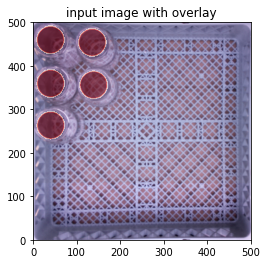

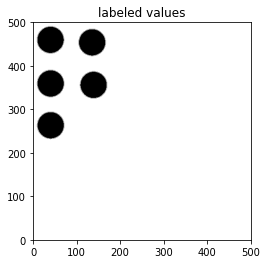

In [12]:
''' visualize a sample. the red on the image is where the opening is. '''

rand_image = iter(master_dataset.take(1)).get_next()

overlay = np.squeeze(np.asarray(rand_image[1], dtype=np.float32), axis=0)
overlay[overlay < 0.1] = None

fig, ax = plt.subplots()
plt.imshow(np.squeeze(rand_image[0], axis=0))
plt.imshow(overlay, cmap='Reds', alpha=0.6)
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.title('input image with overlay')

fig, ax = plt.subplots()
plt.imshow(overlay, cmap='binary')
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.title('labeled values')

In [13]:
''' split the dataset into training and testing '''

training_proportion = 0.8

training_size = int(np.floor(len(master_dataset) * training_proportion))
testing_size = len(master_dataset) - training_size

print('total data points:\t', len(master_dataset))
print('training data points:\t', training_size)
print('testing data points:\t', testing_size)

total data points:	 2720
training data points:	 2176
testing data points:	 544


In [15]:
''' define the model layers '''

# model = keras.Sequential([
#     keras.layers.Input(shape=list(master_dataset.take(1)._flat_shapes[0])),
#     keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation='relu', padding='same'),
#     keras.layers.MaxPooling2D(pool_size=3, strides=None, padding="same"),
#     keras.layers.Conv2D(filters=32, kernel_size=4, activation='relu', padding='same'),
#     keras.layers.MaxPooling2D(pool_size=3, strides=None, padding="same"),
#     keras.layers.BatchNormalization(momentum=0.99),
#     keras.layers.Conv2D(filters=1, kernel_size=3, activation='relu', padding='same')
# ])

l2 = None
model = keras.Sequential([
    keras.layers.Input(
        shape=list(master_dataset.take(1)._flat_shapes[0])[1:], # checks the shape of the 1st input data and manipulates it to make Keras happy
        dtype=np.float32
    ),
    keras.layers.Conv2D(
        filters=16,
        kernel_size=5,
        padding='same',
        activation='relu',
        kernel_initializer='glorot_normal',
        kernel_regularizer=l2
    ),
    keras.layers.BatchNormalization(
        momentum=0.99
    ),
    keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        padding='same',
        activation='relu',
        kernel_initializer='glorot_normal',
        kernel_regularizer=l2
    ),
    keras.layers.BatchNormalization(
        momentum=0.99
    ),
    keras.layers.Conv2D(
        filters=1
        kernel_size=5,
        padding='same',
        activation='relu',
        kernel_initializer='glorot_normal',
        kernel_regularizer=l2
    )
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 500, 16)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 500, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 500, 32)      12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 500, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 500, 500, 5)       4005      
Total params: 18,245
Trainable params: 18,149
Non-trainable params: 96
_________________________________________________________________


In [17]:
print('GPUs Available:\n', tf.config.list_physical_devices('GPU'))

GPUs Available:
 []


In [19]:
# train and evalute the model

model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

hist = model.fit(
    x=master_dataset.take(training_size), 
    epochs=1, # TODO this is just for speed
    shuffle=True
)

loss, acc = model.evaluate(
    x=master_dataset.skip(training_size)
)

print('test accuracy:', acc)
print('test loss:', loss)

544/544 [==============================] - 162s 195ms/step - loss: 5.0981e-04 - accuracy: 0.7930
test accuracy: 0.7929697632789612
test loss: 0.0005098130204714835


In [20]:
''' convert and save model in tflite format '''

from datetime import datetime

# format is YYYYMMDDHHmm
filename = 'model-' + datetime.now().strftime('%Y%m%d%H%M') + '.tflite'
print('writing', filename)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(filename, 'wb') as f:
    f.write(tflite_model)

writing model-202104221811.tflite
INFO:tensorflow:Assets written to: C:\Users\liam\AppData\Local\Temp\tmpfo05tz1m\assets


Text(0.5, 1.0, 'input image with predicted overlay')

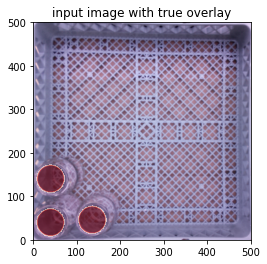

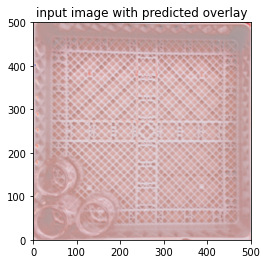

In [37]:
''' test an image and visualise it '''

rand_image = iter(master_dataset.shuffle(20).take(1)).get_next()

pred = model.predict(np.asarray(rand_image[0]))

overlay_true = np.squeeze(np.asarray(rand_image[1], dtype=np.float32), axis=0)
overlay_true[overlay_true < 0.1] = None

overlay_pred = np.squeeze(pred, axis=0)
overlay_pred[overlay_pred < 0.1] = None

fig, ax = plt.subplots()
plt.imshow(np.squeeze(rand_image[0], axis=0))
plt.imshow(overlay_true, cmap='Reds', alpha=0.6)
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.title('input image with true overlay')

fig, ax = plt.subplots()
plt.imshow(np.squeeze(rand_image[0], axis=0))
plt.imshow(overlay_pred, cmap='Reds', alpha=0.6)
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.title('input image with predicted overlay')